In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Relevant Papers

* WBF  - https://arxiv.org/pdf/1910.13302.pdf
* Mosaic augmentation - https://arxiv.org/pdf/2009.07168.pdf
* You Only Look Once - https://arxiv.org/pdf/1506.02640.pdf

In [ ]:
'''
@Auxiliary functions and pre-trained weights from none kaggle env
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install --upgrade --force-reinstall --no-deps albumentations

import os
os.environ['KAGGLE_USERNAME']="NAME"
os.environ['KAGGLE_KEY']="KEY"

!kaggle competitions download -c global-wheat-detection #data set
!unzip global-wheat-detection.zip -d global-wheat-detection

!kaggle datasets download -d vladkozhukhov/yolo-yaml #our scripts for yolov5
!unzip yolov5train -d yolo-yaml

!kaggle datasets download -d vladkozhukhov/trained-yolov5   # private, can be created from this notebook
!unzip yolov5train -d trained-yolov5
'''

In [2]:
import numpy as np
import pandas as pd 
import os
from tqdm.auto import tqdm
import shutil as sh
import torch
import sys
import glob
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import random
import argparse
import torch
import random
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
import cv2
import re
import ast
import matplotlib.pyplot as plt
from typing import List, Union, Tuple
from sklearn.model_selection import train_test_split
import numba
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import time

#Setup thresholds
NMS_IOU_THR = 0.6
NMS_CONF_THR = 0.5
iou_thr = 0.6
skipBox_thr = 0.43 
IMG_SIZE = 1024
# Setup the paths 
TRAIN_DIR = '/kaggle/input/global-wheat-detection/train/'
TEST_DIR = '/kaggle/input/global-wheat-detection/test/'
TRAIN_CSV_PATH = '/kaggle/input/global-wheat-detection/train.csv'
DF_All_FEATURES_CSV_PATH = '/kaggle/input/all-features-data/df_with_all_features (1).csv'
WEIGHTS = '/kaggle/input/yolo-yaml/yolov5x.pt'
TRAINED_WITHOUT_PSEUDO ='/kaggle/input/trained-yolov5/best.pt'
CONFIG = '/kaggle/input/yolo-yaml/yolov5x.yaml'
DATA = '/kaggle/input/yolo-yaml/wheat.yaml'
CONVERTOR_LABELS = 'convertor/labels/'
CONVERTOR_IMAGE = 'convertor/images/'
BEST_WEIGHT = '../input/trained-yolov5/best.pt'
from ast import literal_eval
from PIL import Image, ImageDraw


#Setup mode
PSEUDO_LABELS = True
is_AUG = True
is_ROT = True
VALIDATE = True
enableTTA = True
IMAGE_SIZE = 1024
conf_thres = 0.1
iou_thres = 0.8

from numba import jit
from typing import List, Union, Tuple
iou_thresholds = numba.typed.List()

for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    iou_thresholds.append(x)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

NEW_TRAIN = False

# Data exploration

In [27]:
from glob import glob
train_imgs = glob(TRAIN_DIR + '*')
test_imgs = glob(TEST_DIR + '*')

Number of images

In [28]:
print('Number of train images is {}'.format(len(train_imgs)))
print('Number of test images is {}'.format(len(test_imgs)))

Number of train images is 3422
Number of test images is 10


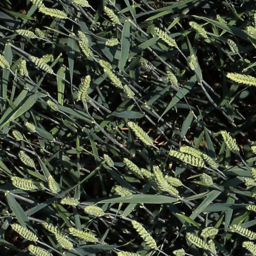

In [29]:
image = Image.open(TRAIN_DIR+ "02640d9da" + ".jpg")
image = image.resize((256, 256))
image

In [ ]:

# Load the dataframe with the bounding boxes
train = pd.read_csv(TRAIN_CSV_PATH)

# Create a dataframe with all train images
all_train_images = pd.DataFrame([fns.split('/')[-1][:-4] for fns in train_imgs])
all_train_images.columns=['image_id']

# Merge all train images with the bounding boxes dataframe
all_train_images = all_train_images.merge(train, on='image_id', how='left')

# replace nan values with zeros
all_train_images['bbox'] = all_train_images.bbox.fillna('[0,0,0,0]')

# split bbox column
bbox_items = all_train_images.bbox.str.split(',', expand=True)
all_train_images['bbox_xmin'] = bbox_items[0].str.strip('[ ').astype(float)
all_train_images['bbox_ymin'] = bbox_items[1].str.strip(' ').astype(float)
all_train_images['bbox_width'] = bbox_items[2].str.strip(' ').astype(float)
all_train_images['bbox_height'] = bbox_items[3].str.strip(' ]').astype(float)

In [ ]:
def printStatsAndHist(data,xname,yname,title):
    ser = pd.Series(data)
    ser.plot.hist(grid=True, bins=20, rwidth=0.9,
                        color='#607c8e')
    plt.title(title)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.grid(axis='y', alpha=0.75)
    plt.show()
    print(ser.describe())

In [ ]:
# compute the number of bounding boxes per train image
all_train_images['count'] = all_train_images.apply(lambda row: 1 if np.isfinite(row.width) else 0, axis=1)
train_images_count = all_train_images.groupby('image_id').sum().reset_index()
printStatsAndHist(train_images_count["count"],'wheat spikes','Count','Number of wheat spikes per image')


In [ ]:
def getAllBboxes(df, image_id):
    image_bboxes = df[df.image_id == image_id]
    
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height))
        
    return bboxes

def plotImageExamples(df, rows=3, cols=3, title='Image examples'):
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].image_id
            
            img = Image.open(TRAIN_DIR + img_id + '.jpg')
            axs[row, col].imshow(img)
            
            bboxes = getAllBboxes(df, img_id)
            
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
                axs[row, col].add_patch(rect)
            
            axs[row, col].axis('off')
            
    plt.suptitle(title)

In [ ]:
plotImageExamples(all_train_images)

In [ ]:
less_spikes_ids = train_images_count[train_images_count['count'] < 10].image_id
plotImageExamples(all_train_images[all_train_images.image_id.isin(less_spikes_ids)], title='Example images with small number of spikes')
print('Images with less than 10 wheat heads: {}'.format(len(less_spikes_ids)))

In [ ]:
many_spikes_ids = train_images_count[train_images_count['count'] > 80].image_id
plotImageExamples(all_train_images[all_train_images.image_id.isin(many_spikes_ids)], title='Example images with big number of spikes')
print('Images with more than 80 wheat heads: {}'.format(len(many_spikes_ids)))

In [ ]:
# compute bounding box areas
all_train_images['bbox_area'] = all_train_images['bbox_width'] * all_train_images['bbox_height']
all_train_images['bbox_area'].describe()

In [ ]:
large_boxes_ids = all_train_images[all_train_images['bbox_area'] > 200000].image_id
plotImageExamples(all_train_images[all_train_images.image_id.isin(large_boxes_ids)], title='Example images with large bbox area')
print('Images with large bbox areas: {}'.format(len(large_boxes_ids)))

In [ ]:
large_area_perc_ids = area_per_image_percentage[area_per_image_percentage['bbox_area'] > 80].image_id
plotImageExamples(all_train_images[all_train_images.image_id.isin(large_area_perc_ids)], title='Example images with large percentage of area covered by bounding boxes')
print('Images with high bbox areas coverage: {}'.format(len(large_area_perc_ids)))

In [ ]:
# compute the total bounding boxes area per image
area_per_image = all_train_images.groupby(by='image_id').sum().reset_index()

# compute the percentage of the image area covered by bounding boxes
area_per_image_percentage = area_per_image.copy()
area_per_image_percentage['bbox_area'] = area_per_image_percentage['bbox_area'] / (1024*1024) * 100

printStatsAndHist(area_per_image_percentage['bbox_area'],'bbox area','count','bbox area per image')

In [ ]:
def getImageBrightness(image):
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # get average brightness
    return np.array(gray).mean()

def addBrightness(df):
    brightness = []
    for _, row in df.iterrows():
        img_id = row.image_id  
        image = cv2.imread(TRAIN_DIR + img_id + '.jpg')
        brightness.append(getImageBrightness(image))
        
    brightness_df = pd.DataFrame(brightness)
    brightness_df.columns = ['brightness']
    df = pd.concat([df, brightness_df], ignore_index=True, axis=1)
    df.columns = ['image_id', 'brightness']
    
    return df

In [ ]:
images_df = pd.DataFrame(all_train_images.image_id.unique())
images_df.columns = ['image_id']
# add brightness to the dataframe
images_df = pd.DataFrame(all_train_images.image_id.unique())
images_df.columns = ['image_id']
brightness_df = addBrightness(images_df)

all_train_images = all_train_images.merge(brightness_df, on='image_id')
all_train_images
printStatsAndHist(all_train_images['bbox_area'],'bbox area','count','bbox area per image')


In [ ]:
sns.countplot(all_train_images['source'])

In [ ]:
dark_ids = all_train_images[all_train_images['brightness'] < 30].image_id
plotImageExamples(all_train_images[all_train_images.image_id.isin(dark_ids)], title='Darkest images')
print('Dark images: {}'.format(len(dark_ids)))

In [ ]:
bright_ids = all_train_images[all_train_images['brightness'] > 130].image_id
plotImageExamples(all_train_images[all_train_images.image_id.isin(bright_ids)], title='Brightest images')
print('bright images: {}'.format(len(bright_ids)))

Images from different sources

#  Install YoloV5 V2

In [30]:
!pip install ensemble-boxes

!git clone https://github.com/ultralytics/yolov5
!mv yolov5/* ./
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 8333, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 8333 (delta 22), reused 24 (delta 13), pack-reused 8288
Receiving objects: 100% (8333/8333), 9.25 MiB | 13.12 MiB/s, done.
Resolving deltas: 100% (5762/5762), done.


https://github.com/ZFTurbo/Weighted-Boxes-Fusion

In [31]:
from ensemble_boxes import *


# Pre Processing and Train base YoloV5(without Pseudo Labels)


In [32]:
#print augmentation config
!cat data/hyp.scratch.yaml

cat: data/hyp.scratch.yaml: No such file or directory


In [33]:
def convertData():
    df = pd.read_csv(TRAIN_CSV_PATH)

    bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
    for i, column in enumerate(['x', 'y', 'w', 'h']):
        df[column] = bboxs[:,i]
    df.drop(columns=['bbox'], inplace=True)
    return df

In [34]:
def convertDataWithCenters():
    df = pd.read_csv(TRAIN_CSV_PATH)
    bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
    for i, column in enumerate(['x', 'y', 'w', 'h']):
        df[column] = bboxs[:,i]
    df.drop(columns=['bbox'], inplace=True)
    df['x_center'] = df['x'] + df['w']/2
    df['y_center'] = df['y'] + df['h']/2
    df['classes'] = 0
    df = df[['image_id','x', 'y', 'w', 'h','x_center','y_center','classes']]
    return df

In [35]:
def convertDataWithMaxMin():
    df = pd.read_csv(TRAIN_CSV_PATH)
    bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
    for i, column in enumerate(['x', 'y', 'w', 'h']):
        df[column] = bboxs[:,i]
    df.drop(columns=['bbox'], inplace=True)
    df['x_center'] = df['x'] + df['w']/2
    df['y_center'] = df['y'] + df['h']/2
    df['x_max'] = df['x'] + df['w']
    df['y_max'] = df['y'] + df['h']
    df['classes'] = 0
    df = df[['image_id','x', 'y','x_max','y_max', 'w', 'h','x_center','y_center','classes']]
    return df

In [36]:
def writeLabels(folderName, name, dt):
    with open(CONVERTOR_LABELS+folderName+name+".txt", 'w+') as f:
            row = (dt[['classes','x_center','y_center','w','h']].astype(float).values)/IMG_SIZE
            row = row.astype(str)
            for val in range(len(row)):
                f.write(' '.join(row[val]))
                f.write("\n")

In [37]:
def convertTrainLabel():
    data = convertDataWithCenters()
    img_ids = list(set(data.image_id))
    img_ids = np.array(img_ids)
    train ,val = train_test_split(img_ids,test_size=0.2)  
    for name, dt in tqdm(data.groupby('image_id')):
        folderName = 'val/' if name in val else 'train/'
        os.makedirs(CONVERTOR_LABELS+folderName, exist_ok=True)
        writeLabels(folderName, name,dt)
        os.makedirs(CONVERTOR_IMAGE+folderName, exist_ok=True)
        sh.copy("/kaggle/input/global-wheat-detection/train/{}.jpg".format(name),'convertor/images/{}/{}.jpg'.format(folderName,name))
    return val

In [38]:
def drawRect(img, bboxes, color=None):
    img = img.copy()
    bboxes = bboxes[:, :4]
    bboxes = bboxes.reshape(-1, 4)
    for bbox in bboxes:
        pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
        img = cv2.rectangle(img.copy(), pt1, pt2, color, int(max(img.shape[:2]) / 200))
    return img

In [39]:
def plotMultipleImg(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=1, ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()

# Train YOLOV5

In [40]:
lstOfValIndex = convertTrainLabel()

  0%|          | 0/3373 [00:00<?, ?it/s]

In [41]:
def trainYoloV5Net(weight):
    # Weights & Biases  (optional)
    %pip install -q wandb
    import wandb
    wandb.login()
    !python train.py --img 1024 --batch 4 --epochs 5 --data /kaggle/input/d/vladkozhukhov/yolo-yaml/wheat.yaml --weights {weight}  --cfg /kaggle/input/d/vladkozhukhov/yolo-yaml/yolov5x.yaml --name yolov5x_4M70fold

In [42]:
from utils.datasets import *
from utils.general import *


# Save weights

In [43]:
def saveModel():
    !apt install zip
    !zip -r model.zip /kaggle/working/runs/
    from IPython.display import FileLink
    FileLink(r'./model.zip')

# TTA

In [44]:
import albumentations as A

marking = convertDataWithMaxMin()
marking.head()

,image_id,x,y,x_max,y_max,w,h,x_center,y_center,classes
0,b6ab77fd7,834.0,222.0,890.0,258.0,56.0,36.0,862.0,240.0,0
1,b6ab77fd7,226.0,548.0,356.0,606.0,130.0,58.0,291.0,577.0,0
2,b6ab77fd7,377.0,504.0,451.0,664.0,74.0,160.0,414.0,584.0,0
3,b6ab77fd7,834.0,95.0,943.0,202.0,109.0,107.0,888.5,148.5,0
4,b6ab77fd7,26.0,144.0,150.0,261.0,124.0,117.0,88.0,202.5,0


,x,y,x_max,y_max,classes
119791,133.0,619.0,256.0,744.0,0
119792,363.0,929.0,483.0,1000.0,0
119793,465.0,115.0,596.0,192.0,0
119794,499.0,896.0,637.0,967.0,0
119795,654.0,838.0,733.0,922.0,0


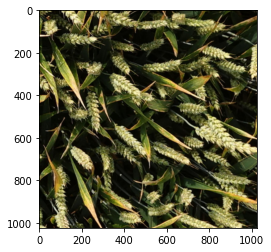

In [45]:
image_folder_path = "/kaggle/input/global-wheat-detection/train/"
chosen_image = cv2.imread(os.path.join(image_folder_path, "234cc40aa.jpg"))[:,:,::-1]
plt.imshow(chosen_image)
chosen_image_dataframe = marking.loc[marking["image_id"]=="234cc40aa",["x","y","x_max","y_max","classes"]]

bbox_array_of_chosen_image = np.array(chosen_image_dataframe.values.tolist())
chosen_image_dataframe.head()

In [46]:
bbox_array_of_chosen_image

array([[        133,         619,         256,         744,           0],
       [        363,         929,         483,        1000,           0],
       [        465,         115,         596,         192,           0],
       [        499,         896,         637,         967,           0],
       [        654,         838,         733,         922,           0],
       [        826,         217,         965,         307,           0],
       [         12,          46,          92,         125,           0],
       [        330,         184,         430,         289,           0],
       [        478,         217,         673,         294,           0],
       [         79,          84,         271,         166,           0],
       [        524,         599,         706,         719,           0],
       [        327,         287,         516,         435,           0],
       [        222,         230,         312,         307,           0],
       [        757,         153,     

In [47]:
class TTA():
    def __init__(self):
        self.ver_flip = A.Compose([A.VerticalFlip(p=1),], bbox_params={'format': 'pascal_voc','label_fields': ['labels']})
        self.hor_flip = A.Compose([A.HorizontalFlip(p=1),], bbox_params={'format': 'pascal_voc','label_fields': ['labels']})
        self.rotate = A.Compose([A.RandomRotate90(p=1),], bbox_params={'format': 'pascal_voc','label_fields': ['labels']})
        self.hsv = A.Compose([A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)],)
        self.contrast =  A.RandomContrast(limit = 0.5,p = 1)
        self.snow = A.RandomSnow(p=1)
        self.rgbShift = A.RGBShift(p=1)
        self.brightness = A.RandomBrightness(p=1)

    def verticalFlip(self,image,bbox): 
        labelsImage = np.ones((len(bbox),))
        ver_flip_annotations = self.ver_flip(image=image, bboxes=bbox, labels=labelsImage)
        ver_flip_annotations['bboxes'] = [list(bbox) for bbox in ver_flip_annotations['bboxes']]
       #ver_flip_img = draw_rect(img = ver_flip_annotations['image'], bboxes = np.array(ver_flip_annotations['bboxes']), color=(255,0,0))
        return ver_flip_annotations['image'], np.array(ver_flip_annotations['bboxes'])
    
    def horizontalFlip(self,image,bbox):
        labelsImage = np.ones((len(bbox),))
        hor_flip_annotations = self.ver_flip(image=image, bboxes=bbox, labels=labelsImage)
        hor_flip_annotations['bboxes'] = [list(bbox) for bbox in hor_flip_annotations['bboxes']]
        return hor_flip_annotations['image'], np.array(hor_flip_annotations['bboxes'])
                                                       
    def brightness(self,image):
        return self.brightness(image = image)['image']
                                                       
    def rgbShift(self,image):
        return self.rgbShift(image = image)['image']
                                                       
    def rotate(self,image,bbox):
        labelsImage = np.ones((len(bbox),))
        rot_annotations = self.rotate(image=image, bboxes=bbox,labels=labelsImage)
        rot_annotations['bboxes'] = [list(bbox) for bbox in rot_annotations['bboxes']]
        return rot_annotations['image'], np.array(rot_annotations['bboxes'])    
    
    def hsv(self,image):
        return self.hsv(image = image)['image']

        

In [48]:
def execTTA(model,enboxes,enscores,targets,img_val,im_id):
    tta = TTA()
    for tta_type in range(0,4):#test to add more Augmentation
        img = img_val.copy()

        if tta_type == 0:
            imgg,bb  = tta.verticalFlip(image = np.array(img),bbox =np.array(targets[im_id]['boxes']))
            boxes, scores =detectWheatHeadOnPicture(imgg, model, aug=True)
            imgg,boxes  = tta.verticalFlip(image = np.array(imgg),bbox =np.array(boxes))

        elif tta_type == 1:
            imgg,bb  = tta.horizontalFlip(image = np.array(img),bbox =np.array(targets[im_id]['boxes']))
            boxes, scores = detectWheatHeadOnPicture(imgg, model, aug=True)
            imgg,boxes  = tta.horizontalFlip(image = np.array(imgg),bbox =np.array(boxes))

        elif tta_type == 2:
            imgg  = tta.hsv(image = np.array(img))['image']
            boxes, scores = detectWheatHeadOnPicture(imgg, model, aug=True)

        else:
            imgg  = tta.brightness(image = np.array(img))['image']
            boxes, scores = detectWheatHeadOnPicture(imgg, model, aug=True)                        

        enboxes.append(boxes)
        enscores.append(scores)
    

WBF https://arxiv.org/abs/1910.13302

In [49]:
def prepareImgForYolo(img):# like in src code of yolov5
    img = img.transpose(2,0,1)
    img = torch.from_numpy(img).to(device)
    img = img.float()  # uint8 to fp16/32
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    return img

def ensembleWBF(boxes, scores, image_size=IMAGE_SIZE, iou_thr=iou_thr, skip_box_thr=skipBox_thr, weights=None):
    labels = [np.zeros(score.shape[0]) for score in scores]
    boxes = [box/(image_size) for box in boxes]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights, iou_thr, skip_box_thr)
    boxes = boxes*(image_size)
    return boxes, scores, labels


def detectWheatHeadOnPicture(srcImg, model, aug=False):
    boxes = []
    scores = []
    srcImg = prepareImgForYolo(srcImg)
    
    pred = model(srcImg, augment=aug)[0]
    pred = non_max_suppression(pred, max_det=400)

    for i, det in enumerate(pred):  # detections per image like in src code of yolov5
        if det is not None and len(det):
            det[:, :4] = scale_coords(srcImg.shape[2:], det[:, :4], (IMAGE_SIZE,IMAGE_SIZE,3)).round()
            # Write results
            for *xyxy, conf, cls in det:
                boxes.append([int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3])])
                scores.append(conf)
                
    return np.array(boxes), np.array(scores)


# Load Model

In [ ]:
def loadModel(weight):
    model = torch.load(weight, map_location=device)['model'].float() 
    model.to(device).eval()
    print('Model is loaded')
    return model

model = loadModel(TRAINED_WITHOUT_PSEUDO)


# Pre-processing and Data Loader Pipeline¶


In [50]:
def getValImages(data,lstOfValIndex):
    df = data[['image_id']].copy()
    df = df[df['image_id'].isin(lstOfValIndex)]
    df.loc[:, 'bbox_count'] = 1
    df = df.groupby('image_id').count()
    df.loc[:, 'source'] = data[['image_id', 'source']].groupby('image_id').min()['source']
    df.loc[:, 'stratify_group'] = np.char.add(df['source'].values.astype(str), df['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str))
    return df

In [51]:
total_df = convertData()
total_df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [52]:

images2Val = getValImages(total_df,lstOfValIndex)
images2Val

,bbox_count,source,stratify_group
image_id,,,
006a994f7,25,inrae_1,inrae_1_1
019d1c76a,32,arvalis_3,arvalis_3_2
029e03e52,54,arvalis_1,arvalis_1_3
02f0fe2ca,17,inrae_1,inrae_1_1
030314634,21,arvalis_2,arvalis_2_1
...,...,...,...
fe125f8a6,74,ethz_1,ethz_1_4
fe133ccb4,57,rres_1,rres_1_3
feb78a8de,46,rres_1,rres_1_3


**Custom Dataloader**
https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html

In [53]:

class DatasetImgTransform(Dataset):

    def __init__(self, data, imageIds, transforms=None):
        super().__init__()
        self.imageIds = imageIds
        self.data = data
        self.transforms = transforms
        
    def getImageAndBoxes(self, idx):
        image_id = self.imageIds[idx]
        img = cv2.imread(f'{TRAIN_DIR}/{image_id}.jpg', cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0
        records = self.data[self.data['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]#x_max
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]#y_max
        return img, boxes
    
    def __getitem__(self, idx: int):
        info_set = {}
        image_id = self.imageIds[idx]
        image, boxes = self.getImageAndBoxes(idx)
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        info_set['boxes'] = boxes
        info_set['labels'] = labels
        info_set['image_id'] = torch.tensor([idx])
        if self.transforms:
            transformed_img = self.transforms(**{'image': image, 'bboxes': boxes, 'labels': labels})
            if len(transformed_img['bboxes']) > 0:
                image = transformed_img['image']
                info_set['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*transformed_img['bboxes'])))).permute(1, 0)
        return image, info_set, image_id

    def __len__(self) -> int:
        return self.imageIds.shape[0]

def collate_fn(batch):
    return tuple(zip(*batch))

# Validate Neural Network

In [73]:

def validateNN(enableTTA = False, valPredictions=[]):
    
    validationDataset = DatasetImgTransform(
        imageIds=images2Val.index.values,
        data=total_df,
        transforms=  A.Compose( [ A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0), ToTensorV2(p=1.0),], 
                                bbox_params=A.BboxParams( format='pascal_voc', label_fields=['labels']))
        )

    validationLoader = DataLoader(
        validationDataset,
        batch_size=1,#each time val 10 images
        shuffle=False,
        num_workers=2,
        drop_last=False,
        collate_fn=collate_fn
        )

    for images, targets, image_ids in tqdm(validationLoader, total=len(validationLoader)):
        images = torch.stack(images)
        images =  images.float()  
        for im_id in range(len(image_ids)):#iterate over batch
            img_val=images[im_id,:,:,:]
            img_val=img_val.cpu().data.numpy()
            img_val=img_val.transpose(1,2,0)
            enboxes = []
            enscores = []
            boxes, scores = detectWheatHeadOnPicture(np.array(img_val), model, aug=enableTTA)#yolov5 aug
            enboxes.append(boxes)
            enscores.append(scores)
            if enableTTA: #add more aug
                execTTA(model,enboxes,enscores,targets,img_val,im_id)                    
            #Trick for TTA like ensemble        
            boxes, scores, labels = ensembleWBF(enboxes, enscores, IMG_SIZE, iou_thr=0.6, skip_box_thr=0.5)
            
            valPredictions.append({
                'pred_boxes': (boxes).clip(min=0, max=1023).astype(int),
                'scores': scores,
                'gt_boxes': (targets[im_id]['boxes'].cpu().numpy()).clip(min=0, max=1023).astype(int),
                'image_id': image_ids[im_id],
            })


In [55]:
    #pascal_voc: [xmin, ymin, xmax, ymax]
    @jit(nopython=True)
    def calculateIOU(prediction, groundTruth):
        xA = max(prediction[0], groundTruth[0])
        yA = max(prediction[1], groundTruth[1])
        xB = min(prediction[2], groundTruth[2])
        yB = min(prediction[3], groundTruth[3])

        interArea = (xB - xA) * (yB - yA)
        
        if interArea == 0:
            return 0.0
        
        boxAArea = (prediction[2] - prediction[0]) * (prediction[3] - prediction[1])
        boxBArea = (groundTruth[2] - groundTruth[0]) * (groundTruth[3] - groundTruth[1])
        if boxAArea < 0 or boxBArea < 0 :
            return 0.0
        
        unionArea = float(boxAArea + boxBArea - interArea)
        
        if unionArea <= 0.0:
            return 0.0
        
        iou = interArea / unionArea
        return iou
    
    


In [56]:
 @jit(nopython=True)
def matchGT(groundTruthLst, prediction, predictionID, threshold , ious):
    bestMatchIOU = 0.0
    bestMatchId= -1
    groundTruthID = 0
    
    for groundTruth in groundTruthLst:
        if groundTruth[0] == -1:
            groundTruthID = groundTruthID + 1
            continue
        
        iouScore = ious[groundTruthID][predictionID]

        if iouScore < 0:
            iouScore = calculateIOU(groundTruth, prediction) 
        
        ious[groundTruthID][predictionID] = iouScore#update matrix

        if iouScore < threshold:
            groundTruthID = groundTruthID + 1
            continue

        if iouScore > bestMatchIOU:
            bestMatchIOU = iouScore
            bestMatchId = groundTruthID
            
        groundTruthID = groundTruthID + 1
        
    return bestMatchId




Precision formula is defined in the competition

In [57]:
def precision(groudtruthLst, predictionLst, threshold = 0.5, ious=None):
    n = len(predictionLst)
    tp = 0
    fp = 0
    for predictionId in range(n):

        bestId = matchGT(groudtruthLst, predictionLst[predictionId], predictionId,threshold=threshold, ious=ious)
        if bestId >= 0:
            tp += 1
            groudtruthLst[bestId] = -1

        else:
            fp += 1

    fn = (groudtruthLst.sum(axis=1) > 0).sum()
    ret = 0
    
    return tp / (tp + fp + fn)

In [58]:
def imagePrecision(gts, preds, thresholds = (0.25, )):
    thresholdsLen = len(thresholds)
    imgp = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1

    for threshold in thresholds:
        precisionThreshold = precision(gts.copy(), preds, threshold=threshold,ious=ious)
        imgp += precisionThreshold / thresholdsLen

    return imgp

In [59]:
def finalScore(valPredictions, score_threshold):
    final_scores = []
    for i in range(len(valPredictions)):
        gt_boxes = valPredictions[i]['gt_boxes'].copy()
        pred_boxes = valPredictions[i]['pred_boxes'].copy()
        scores = valPredictions[i]['scores'].copy()
        image_id = valPredictions[i]['image_id']

        indexes = np.where(scores>score_threshold)
        pred_boxes = pred_boxes[indexes]
        scores = scores[indexes]
    

            
        image_precision = imagePrecision(gt_boxes, pred_boxes,thresholds=iou_thresholds)
        final_scores.append(image_precision)

    return np.mean(final_scores)


In [60]:
def showResult(sample_id, preds, gt_boxes):
    sample = cv2.imread(f'../input/global-wheat-detection/train/{sample_id}.jpg', cv2.IMREAD_COLOR)
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for pred_box in preds:
        cv2.rectangle(
            sample,
            (pred_box[0], pred_box[1]),
            (pred_box[2], pred_box[3]),
            (220, 0, 0), 2
        )
    for gt_box in gt_boxes:    
        cv2.rectangle(
            sample,
            (gt_box[0], gt_box[1]),
            (gt_box[2], gt_box[3]),
            (0, 0, 220), 2
        )
    ax.set_axis_off()
    ax.imshow(sample)
    ax.set_title("RED: Predicted | BLUE - Ground-truth")

In [61]:
def analyzeBestScoreAndTreshold():
    enableTTA= True
    valPredictions = []
    validateNN(enableTTA, valPredictions)
    bestScore, bestThreshold = 0, 0
    for scoreThreshold in tqdm(np.arange(0, 1, 0.01), total=np.arange(0, 1, 0.01).shape[0]):
        finalScore_val = finalScore(valPredictions,scoreThreshold)
        if finalScore_val > bestScore:
            bestScore = finalScore_val
            bestThreshold = scoreThreshold
            
    print('-'*30)
    print(f'[Best Score Threshold]: {bestThreshold}')
    print(f'[OOF Score]: {bestScore:.4f}')
    print('-'*30)
    return bestScore,bestThreshold

# FASTRCNN

In [3]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

# Visualising

In [ ]:
count=0
pcn=[]
enableTTA= True
valPredictions = []
validateNN(enableTTA, valPredictions)



In [ ]:
for i in range(len(valPredictions)):
    gt_boxes = valPredictions[i]['gt_boxes'].copy()
    pred_boxes = valPredictions[i]['pred_boxes'].copy()
    scores = valPredictions[i]['scores'].copy()
    image_id = valPredictions[i]['image_id']

    indexes = np.where(scores>0.45)
    pred_boxes = pred_boxes[indexes]
    scores = scores[indexes]

    img_precision = imagePrecision(gt_boxes, pred_boxes,iou_thresholds)
    pcn.append(img_precision)
    
    if i==6:
        print(f'image {i}: {image_id} \npred boxes: {len(pred_boxes)}   gt boxes: {len(gt_boxes)}')
        print(f'Precision: {img_precision}')
        showResult(image_id, pred_boxes, gt_boxes)
        

In [ ]:
len(valPredictions)

# Pseudo Labels

In [ ]:
def writeNewLabelsboxes(boxes):
    lineo = ''
    for box in boxes:
        x1, y1, w, h = box
        xc, yc, w, h = (x1+w/2)/IMG_SIZE, (y1+h/2)/IMG_SIZE, w/IMG_SIZE, h/IMG_SIZE
        lineo += '0.0 %f %f %f %f\n'%(xc, yc, w, h)

    fileo = open(CONVERTOR_LABELS+image_id+".txt", 'w+')
    fileo.write(lineo)
    ileo.close()
    sh.copy(TEST_DIR+"{}.jpg".format(image_id),CONVERTOR_IMAGE+"{}.jpg".format(image_id))

In [70]:
def getTestImagesBoxes(model,enableTTA = False):
    dataset = LoadImages(TEST_DIR, img_size=IMG_SIZE)
    bestScore,bestThreshold = analyzeBestScoreAndTreshold()

    for path, img_val, img0, vid_cap in dataset:
        im_id = os.path.basename(path).split('.')[0]
        img_val=img_val.transpose(1,2,0)
        img_val = np.array(img_val)  / 255.0
        enboxes = []
        enscores = []
        boxes, scores = detectWheatHeadOnPicture(img_val, model,aug=False)   
        enboxes.append(boxes)
        enscores.append(scores)
        if enableTTA: #add more aug
            boxes, scores = detectWheatHeadOnPicture(img_val, model,aug=enableTTA)   

        #Trick for TTA like ensemble        
        boxes, scores, labels = ensembleWBF(enboxes, enscores, image_size = IMG_SIZE, iou_thr=0.6, skip_box_thr=0.5)
        boxes = boxes.astype(np.int32).clip(min=0, max=IMG_SIZE)

        #covert as train data from xmax ymax to w and h
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        #filter bad predictions
        indices = scores >= bestThreshold
        boxes = boxes[indices]
        scores = scores[indices]
    return boxes,scores

In [67]:
def makePseudolabelAndTrain(model):
    #write labels
    writeNewLabelsboxes(getTestImagesBoxes(model)[0])
    #train our model
    trainYoloV5Net(TRAINED_WITHOUT_PSEUDO)


[[](http://)](http://)# Prediction

In [21]:
def collate_fn(batch):
    return tuple(zip(*batch))
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])




In [ ]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

def makePrediction():
    model = loadModel(BEST_WEIGHT)
    dataset = LoadImages(TEST_DIR, img_size=1024)

    results = []
    count = 0
    boxes,scores =getTestImagesBoxes(model)
    result = {
        'image_id': image_id,
        'PredictionString': format_prediction_string(boxes, scores)
    }

    results.append(result)
    return results

In [69]:
import torch
import torch.onnx as onnx
import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
def makeEnsemblePrediction():
    #load yolov5 and predict test imgs
    yolov5_model = loadModel(BEST_WEIGHT)
    dataset = LoadImages(TEST_DIR, img_size=1024)
    total_boxes = []
    total_scores =[]
    results = []
    count = 0
    boxes,scores = getTestImagesBoxes(yolov5_model)
    
    total_boxes.append(boxes)
    total_scores.append(scores)

    
    
    #
    #
    #load F_RCNN
    #
    #get predictions test images
    #
    #
    #apppend boxes and scores to total_boxes and total_scores
    
    fasterrcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    num_classes = 2 # wheat head + background (background required for fRCNN)
    input_features = fasterrcnn.roi_heads.box_predictor.cls_score.in_features

    # Replace pretrained head with new, untrained fRCNN predictor
    fasterrcnn.roi_heads.box_predictor = FastRCNNPredictor(input_features, num_classes)
    fasterrcnn.load_state_dict(torch.load("/kaggle/input/rasterrcnn-training-result/fasterrcnn_training_result.pth"))
    fasterrcnn.eval()
    x = fasterrcnn.to(device)
    
    test_df = pd.read_csv('/kaggle/input/global-wheat-detection/sample_submission.csv')


    test_dataset = WheatTestDataset(test_df, TEST_DIR,get_test_transform())

    test_data_loader = DataLoader(
        test_dataset,
        batch_size=len(test_df["image_id"]),
        shuffle=False,
       # num_workers=4,
        drop_last=False,
        collate_fn=collate_fn
    )
    fasterrcnn_boxes = []
    fasterrcnn_scores = []
    for images, image_ids in test_data_loader:

        images = list(image.to(device) for image in images)
        outputs = model(images)
        print(len(images))
        for i, image in enumerate(images):

            boxes = outputs[i]['boxes'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()

            boxes = boxes[scores >= 0.25].astype(np.int32)
            scores = scores[scores >= 0.25]
            image_id = image_ids[i]

            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    
        fasterrcnn_boxes.append(boxes) 
        fasterrcnn_scores.append(scores)
    total_boxes.append(fasterrcnn_boxes)
    total_scores.append(fasterrcnn_scores)
    '''
    Example of boxes ensembling for 2 models below.

    First model predicts 5 boxes, second model predicts 4 boxes.
    Confidence scores for each box model 1: [0.9, 0.8, 0.2, 0.4, 0.7]
    Confidence scores for each box model 2: [0.5, 0.8, 0.7, 0.3]
    Labels (classes) for each box model 1: [0, 1, 0, 1, 1]
    Labels (classes) for each box model 2: [1, 1, 1, 0]
    We set weight for 1st model to be 2, and weight for second model to be 1.
    We set intersection over union for boxes to be match: iou_thr = 0.5
    We skip boxes with confidence lower than skip_box_thr = 0.0001
    from ensemble_boxes import *

    boxes_list = [[
        [0.00, 0.51, 0.81, 0.91],
        [0.10, 0.31, 0.71, 0.61],
        [0.01, 0.32, 0.83, 0.93],
        [0.02, 0.53, 0.11, 0.94],
        [0.03, 0.24, 0.12, 0.35],
    ],[
        [0.04, 0.56, 0.84, 0.92],
        [0.12, 0.33, 0.72, 0.64],
        [0.38, 0.66, 0.79, 0.95],
        [0.08, 0.49, 0.21, 0.89],
    ]]
    scores_list = [[0.9, 0.8, 0.2, 0.4, 0.7], [0.5, 0.8, 0.7, 0.3]]
    labels_list = [[0, 1, 0, 1, 1], [1, 1, 1, 0]]
    weights = [2, 1]

    '''
    
    
    
    
    weights = [3, 1] #yolov5 weight 1 and F_RCNN weight 2

    boxes, scores, labels = ensembleWBF(total_boxes, total_scores,image_size = IMG_SIZE, iou_thr=0.6, skip_box_thr=0.5, weights=weights)

    result = {
        'image_id': image_id,
        'PredictionString': format_prediction_string(boxes, scores)
    }

    results.append(result)
    return results

In [ ]:
#trainYoloV5Net(WEIGHTS)
#model = loadModel(TRAINED_WITHOUT_PSEUDO)
#makePseudolabelAndTrain(model)
#model = loadModel(TRAINED_WITHOUT_PSEUDO)
#results = makePrediction()#predict on best
#results    
#makeEnsemblePrediction()